In [1]:

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
import itertools
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth( device=gpu, enable=True)

In [2]:
tf.config.experimental.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
d_len=len(y_train)
x_train,x_val,y_train,y_val=train_test_split(x_train, y_train, test_size=d_len//10*2)

In [4]:
class DataGenerator(utils.Sequence):
    def __init__(self,data,label,batch_size=32,shuffle=False):
        super().__init__()
        self.dataset=np.empty([1]+(list(data.shape)+[1]))
        self.dataset[0,...,0]=data
        self.labels=np.empty([1]+(list(label.shape)))
        self.labels[0,...]=label
        
        self.dataset=self.dataset.transpose(1,0,2,3,4)
        self.labels=self.labels.transpose(1,0,)
        
        self.batch_size=batch_size
        self.shuffle=shuffle
    def __len__(self):
        return len(self.dataset)//self.batch_size
    def __getitem__(self,index):
        x=self.dataset[index*self.batch_size:(index+1)*self.batch_size]/255.
        y=self.labels[index*self.batch_size:(index+1)*self.batch_size]
        return x,y
    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        if self.shuffle:
            order=np.random.permutation(len(self.dataset))
            self.dataset=self.dataset[order]
            self.labels=self.labels[order]
        for item in (self[i] for i in range(self.__len__())):
            yield item

In [5]:
way =10
max_epoch = 40
BATCH_SIZE=128

gen_train=DataGenerator(x_train,y_train,batch_size=BATCH_SIZE,shuffle=True)
gen_val=DataGenerator(x_val,y_val,batch_size=BATCH_SIZE,shuffle=True)
len(gen_train), len(gen_val)

(375, 93)

Support


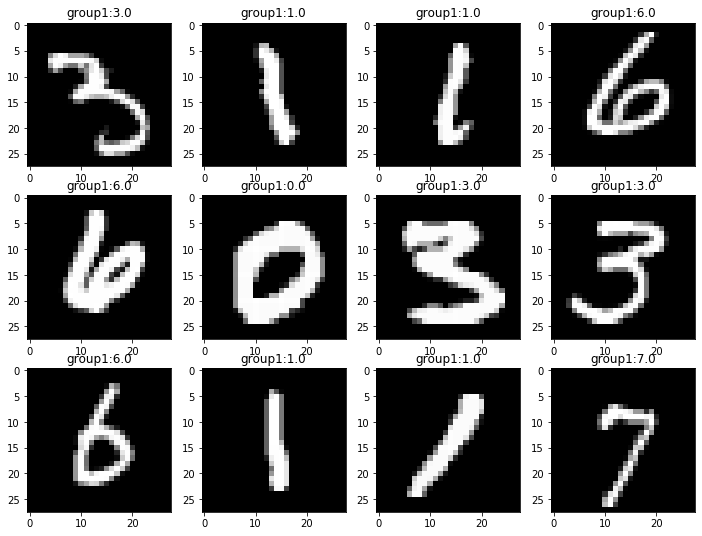

In [6]:
for batch_data,batch_label in gen_train:
    break
gp=1
print("Support")
n_row=3
n_col=4
plt.figure(figsize=(n_col*3,n_row*3))
ee=1
for ii in range(n_row):
    for jj in range(n_col):
        plt.subplot(n_row,n_col,ee)
        plt.imshow(batch_data[ee,0,...,0],"gray")
        plt.title(f"group{gp}:{batch_label[ee,0]}")
        ee+=1
plt.show()

In [7]:
class CNN_model(keras.Model):
    def __init__(self, N_HIDDEN,in_ch,num_cls):
        super().__init__()
#         self.initializer = keras.initializers.HeNormal()
        self.block1 = self.build_block(N_HIDDEN,in_ch)
        self.block2 = self.build_block(N_HIDDEN*2,N_HIDDEN)
        self.gap=keras.layers.GlobalAveragePooling2D()
        self.flat = keras.layers.Flatten()
        self.out = keras.layers.Dense(num_cls, activation='softmax')
    def build_block(self,h_out,h_in):
        return keras.models.Sequential([
            keras.layers.Conv2D(h_out,h_in, padding='same'),
#             keras.layers.BatchNormalization(),
            keras.layers.Activation(keras.activations.relu),
            keras.layers.MaxPooling2D()])
    def forward(self, x):
        x = self.block1(x)
        x = keras.layers.Dropout(0.2)(x)
        x = self.block2(x)
        x = keras.layers.Dropout(0.2)(x)
        x = self.gap(x)
        x = self.flat(x)
        y = self.out(x)
        return y
    
class LSTM_model(keras.Model):
    def __init__(self,n_units):
        super().__init__()
        self.initializer = keras.initializers.he_normal()
        self.lstm1 = keras.layers.LSTMCell(n_units,dropout=0.2, recurrent_dropout=0.2,kernel_initializer=self.initializer)
        self.lstm2 = keras.layers.LSTMCell(n_units,dropout=0.2, recurrent_dropout=0.2,kernel_initializer=self.initializer)
        self.rnn= keras.layers.RNN([self.lstm1,self.lstm2],return_sequences=True,stateful=True)
        self.out=keras.layers.Dense(1,kernel_initializer=self.initializer)
    def forward(self, x):
        x = self.rnn(x)
        y = self.out(x)
        return y

In [16]:
cnn.weights[0].shape

TensorShape([1, 1, 1, 8])

In [8]:
cnn=CNN_model(8,in_ch=1,num_cls=way)
lstm=LSTM_model(32)


In [9]:
# print(cnn.trainable_weights[0][0][0][0][0],cnn.trainable_weights[0][0][0][0][1])
# assign_sub(new_update,cnn.trainable_weights)
# print(cnn.trainable_weights[0][0][0][0][0],cnn.trainable_weights[0][0][0][0][1])

In [10]:
cnn.forward(np.zeros((1,64,64,1)))
cnn_param_num=sum([np.prod(ww.shape) for ww in cnn.trainable_weights])
lstm.forward(np.zeros((cnn_param_num,1,1)))

opt_rnn=keras.optimizers.Adam(lr=0.001)
opt_cnn=keras.optimizers.Adam(lr=0.001)

cnn_loss_fn=keras.losses.categorical_crossentropy
lstm_loss_fn1=keras.losses.cosine_similarity
lstm_loss_fn2=keras.losses.mae
acc_fn = keras.metrics.categorical_accuracy


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [11]:
# train_loss_log = tf.keras.metrics.Mean(name='train_loss')
# train_accuracy_log = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

# test_loss_log = tf.keras.metrics.Mean(name='test_loss')
# test_accuracy_log = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

# @tf.function
# def train_step(meta_data, meta_label):
#     train_acc=[]
#     for ii,(data,label) in enumerate(zip(meta_data,meta_label)):
#         if ii==0:
#             flt_grads=np.random.rand(cnn_param_num,1,1)
#             for cell in lstm.rnn.states:
#                 for ss in cell:
#                     ss.assign(np.zeros(ss.shape))
#         else:
#             flt_grads=flat_tensors(grads1)
#         with tf.GradientTape() as tape2:
#             new_update=lstm(flt_grads)
#             assign_sub(new_update,cnn.trainable_weights)
#             with tf.GradientTape() as tape1:
#                 logits=cnn(data)
#                 loss1=cnn_loss_fn(label, logits)
#             grads1=tape1.gradient(loss1,cnn.trainable_weights)
#             flt_grads2=flat_tensors(grads1)
#             loss2=lstm_loss_fn(flt_grads2*meta_lr, new_update)
#         grads3=tape2.gradient(loss2,lstm.trainable_weights)
#         opt_rnn.apply_gradients(zip(grads3, lstm.trainable_weights))
#         acc=acc_fn(label.argmax(-1),logits).numpy().mean()
#         train_acc.append(acc)
#     train_loss_log(loss1)
#     train_accuracy_log(label, logits)

In [12]:
def flat_tensors(tensors):
    tensors=tf.keras.layers.Concatenate()([tf.reshape(tens,[-1]) for tens in tensors])
    return tf.reshape(tensors,(len(tensors),1,1))
# def reshape_tensors_as(tensors,ref):
#     tensor_reshaped=[]
#     nn=0
#     for layer in ref:
#         flt_len=np.prod(layer.shape)
#         tensor_reshaped.append(tf.reshape(tensors[nn:nn+flt_len],layer.shape))
#         nn+=flt_len
#     return tensor_reshaped
def assign_sub(tensors,ref):
    nn=0
    for w in ref:
        flt_len=np.prod(w.shape)
        w.assign_add(tf.reshape(tensors[nn:nn+flt_len],w.shape))
        nn+=flt_len

In [13]:
meta_lr=0.001
for epoch in range(max_epoch):
    train_sess=tqdm(gen_train)
    val_sess=tqdm(gen_val)
    
    for batch_data,batch_label in gen_train:
        train_acc=[]
        
        for ii,(data,label) in enumerate(zip(batch_data,batch_label)):
        
            label_1_hot = tf.one_hot(tf.cast(label, tf.int32),depth=way)
            if ii==0:
                flt_grads=np.random.rand(cnn_param_num,1,1)
                for cell in lstm.rnn.states:
                    for ss in cell:
                        ss.assign(np.zeros(ss.shape))
            else:
                flt_grads=flt_grads2
            with tf.GradientTape(persistent=True) as tape2:
                new_update=lstm.forward(flt_grads)
                assign_sub(new_update,cnn.trainable_weights)
                logits=cnn.forward(data)
                loss1=cnn_loss_fn(label_1_hot, logits)+tf.sqrt(tf.reduce_mean(new_update**2))*0.5
            grads1=tape2.gradient(loss1,cnn.trainable_weights)
            flt_grads2=flat_tensors(grads1)
        #                 loss2=lstm_loss_fn1(flt_grads2, new_update)
        #             grads3=tape2.gradient(loss2,lstm.trainable_weights)
            grads4=tape2.gradient(new_update,lstm.trainable_weights,output_gradients=-flt_grads2)

            opt_rnn.apply_gradients(zip(grads4, lstm.trainable_weights))
        #             opt_cnn.apply_gradients(zip(grads1, cnn.trainable_weights))
            acc=acc_fn(label_1_hot,logits).numpy().mean()
            train_acc.append(acc)

        train_sess.set_postfix({"CNN loss": loss1.numpy().mean(),"acc":np.mean(train_acc)})
#     for meta_data,meta_label in gen_val:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


KeyboardInterrupt: 

In [26]:
new_update.shape

TensorShape([8394, 1, 1])

Support


NameError: name 'data' is not defined

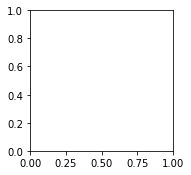

In [13]:
gp=1
print("Support")
plt.figure(figsize=(7*3,5*3))
ee=1
for ii in range(4):
    for jj in range(8):
        plt.subplot(5,7,ee)
        plt.imshow(data[ee-1,...,0],"gray")
        plt.title(f"{label[ee-1]}")
        ee+=1
plt.show()

# Normal way to 

In [12]:

for epoch in range(max_epoch):
    train_sess=tqdm(gen_train)
    val_sess=tqdm(gen_val)
    for batch_data,batch_label in train_sess:
#         p = np.random.permutation(len(meta_label))
#         meta_data=meta_data[p]
#         meta_label=meta_label[p]
        data=batch_data[:,0,...]
        label=batch_label[:,0]
#         lstm.rnn.reset_states()
        train_acc=[]
        label_1_hot = tf.one_hot(tf.cast(label, tf.int32),depth=way)
        with tf.GradientTape() as tape2:
            logits=cnn.forward(data)
#                 loss1=cnn_loss_fn(label_1_hot, logits)+tf.sqrt(tf.reduce_mean(flat_tensors(cnn.trainable_weights)**2))*0.5
            loss1=cnn_loss_fn(label_1_hot, logits)
        grads1=tape2.gradient(loss1,cnn.trainable_weights)    
        opt_cnn.apply_gradients(zip(grads1, cnn.trainable_weights))
        acc=acc_fn(label_1_hot,logits).numpy().mean()
        train_acc.append(acc)
            
        train_sess.set_postfix({"CNN loss": loss1.numpy().mean(),"acc":np.mean(train_acc)})
#     for meta_data,meta_label in gen_val:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


KeyboardInterrupt: 

In [32]:
label_1_hot

<tf.Tensor: id=144, shape=(128, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)>

In [26]:
label

array([8., 5., 3., 3., 4., 2., 1., 2., 8., 6., 3., 1., 1., 4., 3., 1., 3.,
       0., 8., 6., 8., 3., 0., 7., 6., 6., 0., 9., 2., 1., 7., 1., 8., 0.,
       8., 6., 9., 4., 1., 8., 2., 7., 5., 1., 9., 0., 9., 5., 7., 8., 8.,
       8., 7., 2., 7., 6., 1., 2., 3., 7., 9., 3., 3., 6., 8., 6., 1., 4.,
       7., 1., 3., 1., 9., 0., 4., 0., 6., 1., 1., 9., 1., 3., 2., 0., 8.,
       8., 3., 8., 2., 9., 7., 0., 5., 1., 1., 6., 9., 3., 3., 2., 4., 1.,
       7., 2., 0., 2., 8., 7., 0., 4., 5., 0., 2., 0., 3., 8., 4., 8., 4.,
       4., 5., 8., 7., 2., 5., 9., 7., 8.])

Text(0.5, 1.0, '[8.]')

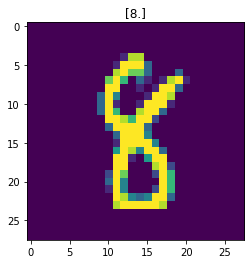

In [35]:
nn=31
plt.imshow(batch_data[nn,0,...,0])
plt.title(batch_label[nn])

In [36]:
logits=cnn(data)

In [56]:
list(zip(meta_data,meta_label)).__len__()

40

In [25]:
logits.numpy().argmax(-1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [66]:
flt_grads=tf.Variable(np.zeros((cnn_param_num,1,1)))
for ii,(data,label) in enumerate(zip(meta_batch,ans)):
    lstm(flt_grads.numpy())
    
    with tf.GradientTape() as tape:
        logits=cnn(data)
        loss=tf.reduce_mean(keras.losses.categorical_crossentropy(label, logits))
    grads=tape.gradient(loss,cnn.trainable_weights)
    flt_grads=flat_tensors(grads)
    
    for ii==0:
        flt_grads=tf.Variables(np.zeros((cnn_param_num,1,1)))
        
    with tf.GradientTape() as tape2:
        update_val=lstm(flt_grads.numpy())
        assign_add(update_val[0],cnn.trainable_weights)
        logits=cnn(data)
        loss2=tf.reduce_mean(keras.losses.categorical_crossentropy(label, logits))
    grads2=tape2.gradient(loss2,cnn.trainable_weights)
    break
    